In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import axes3d
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [3]:
loan_raw=pd.read_csv('loan.csv')
applicant_raw=pd.read_csv('applicant.csv')

print('Output 1:','\n','Loan (Row & Column)',loan_raw.shape)
print('Applicant (Row & Column)',applicant_raw.shape,'\n')

# Merging the data
data_raw=pd.merge(left = loan_raw, right = applicant_raw, left_on='applicant_id', right_on='applicant_id', how='left')
# print('Output 2: Data (data type of columns)','\n',data_raw.dtypes,'\n')

data_raw.head()
data_raw.describe()

Output 1: 
 Loan (Row & Column) (1000, 13)
Applicant (Row & Column) (1000, 15) 



,applicant_id,Months_loan_taken_for,Principal_loan_amount,EMI_rate_in_percentage_of_disposable_income,Has_coapplicant,Has_guarantor,Number_of_existing_loans_at_this_bank,high_risk_applicant,Primary_applicant_age_in_years,Number_of_dependents,Years_at_current_residence,Foreign_worker
count,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.514763e+06,20.903000,3.271258e+06,2.973000,0.041000,0.052000,1.407000,0.300000,35.546000,1.155000,2.845000,0.963000
std,2.286764e+05,12.058814,2.822737e+06,1.118715,0.198389,0.222138,0.577654,0.458487,11.375469,0.362086,1.103718,0.188856
min,1.105364e+06,4.000000,2.500000e+05,1.000000,0.000000,0.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.321398e+06,12.000000,1.365500e+06,2.000000,0.000000,0.000000,1.000000,0.000000,27.000000,1.000000,2.000000,1.000000
50%,1.529114e+06,18.000000,2.319500e+06,3.000000,0.000000,0.000000,1.000000,0.000000,33.000000,1.000000,3.000000,1.000000
75%,1.707752e+06,24.000000,3.972250e+06,4.000000,0.000000,0.000000,2.000000,1.000000,42.000000,1.000000,4.000000,1.000000
max,1.903505e+06,72.000000,1.842400e+07,4.000000,1.000000,1.000000,4.000000,1.000000,75.000000,2.000000,4.000000,1.000000


In [4]:
#  Missing values check and value imputation
data_missing = data_raw.copy()

print('Output 1: Missing values in data:','\n',data_raw.isna().sum().where(lambda x : x>0).dropna(),'\n')

# Imputing with adding 'missing' in the columns
data_missing['Purpose'].fillna('Missing', inplace=True)
data_missing['Property'].fillna('Missing', inplace=True)
data_missing['Other_EMI_plans'].fillna('Missing', inplace=True)
data_missing['Has_been_employed_for_at_least'].fillna('Missing', inplace=True)
data_missing['Has_been_employed_for_at_most'].fillna('Missing', inplace=True)
data_missing['Telephone'].fillna('Missing', inplace=True)
data_missing['Savings_account_balance'].fillna('Missing', inplace=True)
data_missing['Balance_in_existing_bank_account_(lower_limit_of_bucket)'].fillna('Missing', inplace=True)
data_missing['Balance_in_existing_bank_account_(upper_limit_of_bucket)'].fillna('Missing', inplace=True)


# Feature Engineering:
# 1. Creating monthly EMI ($) that applicant needs to pay (Formula = [Principal × rate × (1 + rate)^Tenure]/[(1 + rate)^(Tenure - 1)]
data_missing['EMI_rate_in_percentage_of_disposable_income'] =  (data_missing['EMI_rate_in_percentage_of_disposable_income'])/100
Principal = data_missing['Principal_loan_amount']
Rate = data_missing['EMI_rate_in_percentage_of_disposable_income'] 
Tenure = data_missing['Months_loan_taken_for'] 
data_missing['Monthly_EMI'] =  Principal * Rate * ((1 + Rate)**Tenure/(((1 + Rate)**Tenure) - 1))

# 2. Monthly EMI to Principal ratio
data_missing['EMI_to_Principal_Ratio'] = data_missing['Monthly_EMI']/data_missing['Principal_loan_amount']


Output 1: Missing values in data: 
 Purpose                                                      12.0
Property                                                    154.0
Other_EMI_plans                                             814.0
Has_been_employed_for_at_least                               62.0
Has_been_employed_for_at_most                               253.0
Telephone                                                   596.0
Savings_account_balance                                     183.0
Balance_in_existing_bank_account_(lower_limit_of_bucket)    668.0
Balance_in_existing_bank_account_(upper_limit_of_bucket)    457.0
dtype: float64 



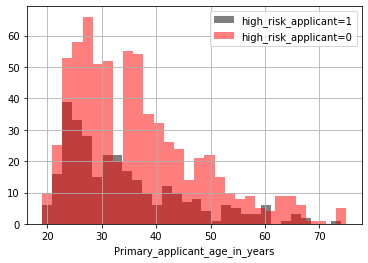

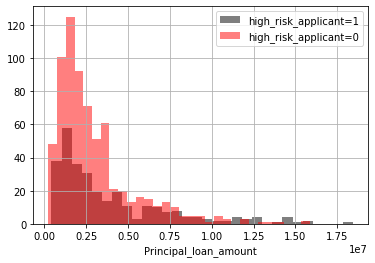

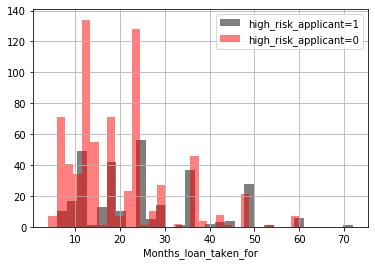

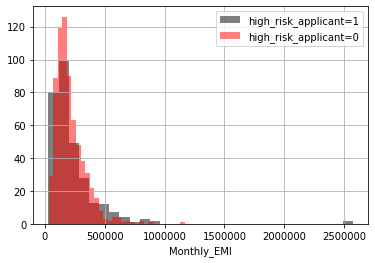

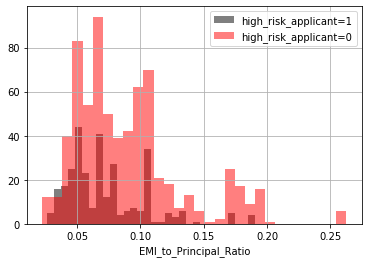

In [5]:
# Checking the distribution of numeric variables by risk applicant category
# 1. How does age of applicant affect risk rate?
# 2. How does risk rate vary with loan amount?
# 3. How does loan tenure affect risk rate?
# 4. What is the impact of EMI amount ($) on risk rate?
# 5. How does financial capability of the customer affect risk rate?

def Distribution(col):
    plt.figure(figsize=(6,4))
    data_missing[data_missing['high_risk_applicant']==1][col].hist(alpha=0.5,color='black', bins=30,label='high_risk_applicant=1')
    data_missing[data_missing['high_risk_applicant']==0][col].hist(alpha=0.5,color='red', bins=30,label='high_risk_applicant=0')
    plt.legend()
    plt.xlabel(col)
    
Distribution('Primary_applicant_age_in_years')
Distribution('Principal_loan_amount')
Distribution('Months_loan_taken_for')
Distribution('Monthly_EMI')
Distribution('EMI_to_Principal_Ratio')

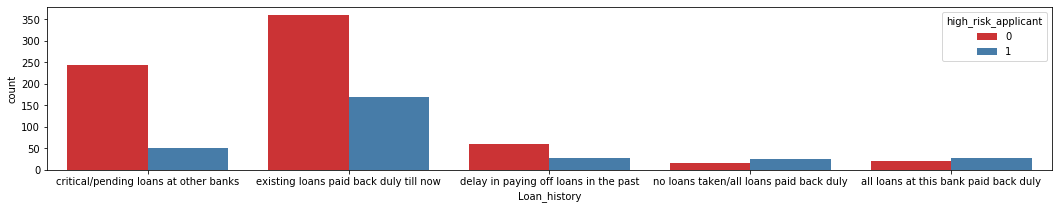

In [6]:
def Frequency(col):
    plt.figure(figsize=(18,3))
    sns.countplot(x=col,hue='high_risk_applicant',data=data_missing,palette='Set1')
    
Frequency('Loan_history')
# Frequency('Purpose')
# Frequency('Property')
# Frequency('Other_EMI_plans')
# Frequency('Gender')
# Frequency('Marital_status')
# Frequency('Housing')
# Frequency('Employment_status')

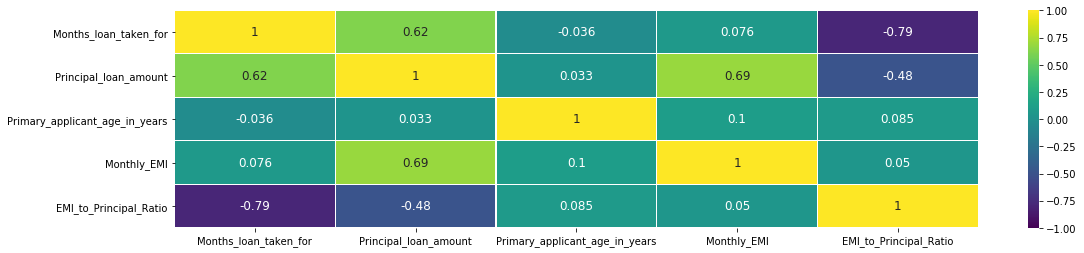

In [7]:
# Correlation for numeric variables (Will be helpful in Logistic regression and in feature selection in ML techniques)
corr = data_missing[['Months_loan_taken_for','Principal_loan_amount','Primary_applicant_age_in_years','Monthly_EMI','EMI_to_Principal_Ratio']].corr() 
plt.figure(figsize=(18, 4))
sns.heatmap(corr,cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,annot=True, annot_kws={"size": 12}, square=False);

# of applicants: 1000 
 # of High risk applicants: 300 
 Portfolio Response Rate: 0.3 

Variable: Purpose 
                       sum  count        RR
Purpose                                   
FF&E                   58    181  0.320442
Missing                 5     12  0.416667
business               34     97  0.350515
career development      1      9  0.111111
domestic appliances     4     12  0.333333
education              22     50  0.440000
electronic equipment   62    280  0.221429
new vehicle            89    234  0.380342
repair costs            8     22  0.363636
used vehicle           17    103  0.165049 

Variable: Property 
                                                    sum  count        RR
Property                                                               
Missing                                             67    154  0.435065
building society savings agreement/life insurance   71    232  0.306034
car or other                                       102    332  0.

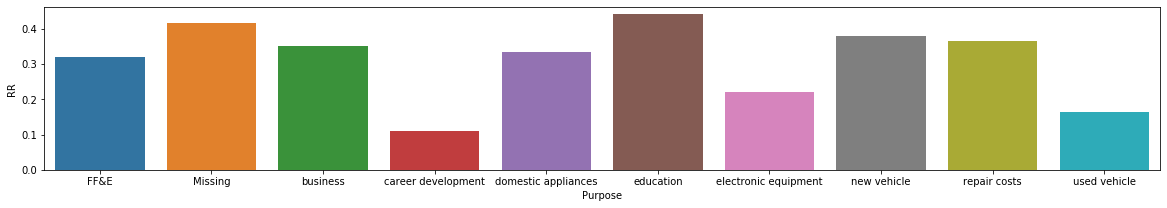

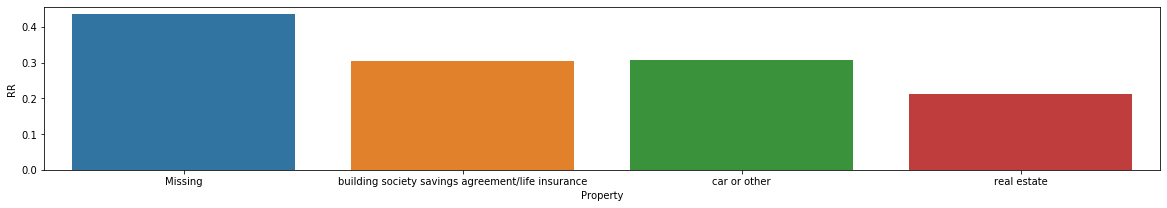

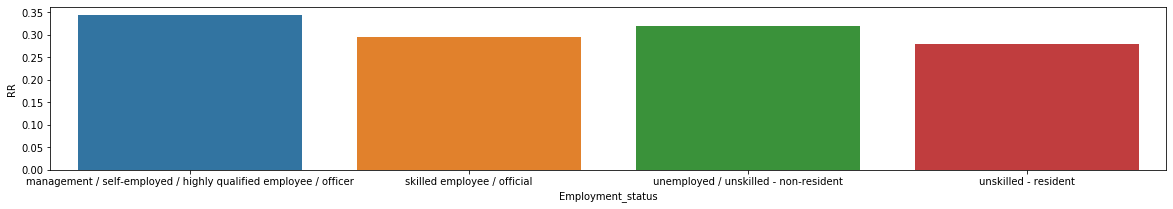

In [8]:
# Response Rate (Understanding the relationship between risk rate and the variable)

data_EDA = data_missing

print('# of applicants:',len(data_EDA),'\n',
      '# of High risk applicants:',data_EDA['high_risk_applicant'].sum(),'\n',
      'Portfolio Response Rate:',data_EDA['high_risk_applicant'].sum()/len(data_EDA),'\n')

# Response rate by categories for character data type columns 
def RR_category(col):
    RR_temp = data_EDA.groupby(col)['high_risk_applicant'].agg(['sum','count'])
    RR_temp['RR']=RR_temp['sum']/RR_temp['count']
    print('Variable:',col,'\n',RR_temp,'\n')
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.barplot(y=RR_temp['RR'], x=RR_temp.index)

def RR_numeric(variable):
    Decile_temp=data_EDA
    Decile_temp['Decile'] = pd.qcut(Decile_temp[variable], 10,labels = False, duplicates='drop') 

    RR_temp = Decile_temp.groupby('Decile').agg({variable:['mean'], 'high_risk_applicant':['sum','count']})
    RR_temp.columns=['Var','sum','count']
    RR_temp['RR']=RR_temp['sum']/RR_temp['count']
    print('Variable:',variable,'\n',RR_temp,'\n')
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.lineplot(y=RR_temp['RR'], x=RR_temp['Var'].round(1))

# RR_numeric('Months_loan_taken_for')
# RR_numeric('Principal_loan_amount')
# RR_numeric('Primary_applicant_age_in_years')
# RR_numeric('EMI_to_Principal_Ratio')
# RR_numeric('Monthly_EMI')

RR_category('Purpose')
RR_category('Property')
RR_category('Employment_status')
# RR_category('Loan_history')
# RR_category('Number_of_existing_loans_at_this_bank')
# RR_category('Has_coapplicant')
# RR_category('Has_guarantor')
# RR_category('Number_of_dependents')
# RR_category('Years_at_current_residence')
# RR_category('Foreign_worker')
# RR_category('EMI_rate_in_percentage_of_disposable_income')
# RR_category('Number_of_existing_loans_at_this_bank')


In [9]:
# Information Value (Understanding the important of features)
data_IV=data_missing

print('Information Value (IV) of variables','\n')
def IV(col, col_type):
    if col_type=='char':
        IV_temp = data_IV.groupby(col)['high_risk_applicant'].agg(['sum','count'])
    elif col_type=='num':
        data_IV['Decile'] = pd.qcut(data_IV[col], 10,labels = False, duplicates='drop') 
        IV_temp = data_IV.groupby('Decile')['high_risk_applicant'].agg(['sum','count'])
    
    IV_temp['Goods']=IV_temp['sum']
    IV_temp['Bad']=(IV_temp['count']-IV_temp['sum'])
    IV_temp['percent_Goods']=IV_temp['Goods']/IV_temp['Goods'].sum()
    IV_temp['percent_Bads']=IV_temp['Bad']/IV_temp['Bad'].sum()
    IV_temp['IV']=np.log(IV_temp['percent_Goods']/IV_temp['percent_Bads'])*(IV_temp['percent_Goods'] - IV_temp['percent_Bads'])
    print('Variable:',col,'=',IV_temp['IV'].sum().round(3))
    
IV('EMI_rate_in_percentage_of_disposable_income','char')
IV('Has_coapplicant','char')
IV('Has_guarantor','char')
IV('Number_of_existing_loans_at_this_bank','char')
IV('Number_of_dependents','char')
IV('Years_at_current_residence','char')
IV('Foreign_worker','char')
IV('Purpose','char')
IV('Property','char')
IV('Other_EMI_plans','char')
IV('Loan_history','char')
IV('Gender','char')
IV('Marital_status','char')
IV('Housing','char')
IV('Employment_status','char')
IV('Has_been_employed_for_at_least','char')
IV('Has_been_employed_for_at_most','char')
IV('Telephone','char')
IV('Savings_account_balance','char')
IV('Balance_in_existing_bank_account_(lower_limit_of_bucket)','char')
IV('Balance_in_existing_bank_account_(upper_limit_of_bucket)','char')

IV('Months_loan_taken_for','num')
IV('Principal_loan_amount','num')
IV('Primary_applicant_age_in_years','num')
IV('Monthly_EMI','num')
IV('EMI_to_Principal_Ratio','num')


Information Value (IV) of variables 

Variable: EMI_rate_in_percentage_of_disposable_income = 0.026
Variable: Has_coapplicant = 0.017
Variable: Has_guarantor = 0.016
Variable: Number_of_existing_loans_at_this_bank = 0.013
Variable: Number_of_dependents = 0.0
Variable: Years_at_current_residence = 0.004
Variable: Foreign_worker = 0.044
Variable: Purpose = 0.169
Variable: Property = 0.113
Variable: Other_EMI_plans = 0.058
Variable: Loan_history = 0.293
Variable: Gender = 0.027
Variable: Marital_status = 0.045
Variable: Housing = 0.083
Variable: Employment_status = 0.009
Variable: Has_been_employed_for_at_least = 0.086
Variable: Has_been_employed_for_at_most = 0.086
Variable: Telephone = 0.006
Variable: Savings_account_balance = 0.196
Variable: Balance_in_existing_bank_account_(lower_limit_of_bucket) = 0.069
Variable: Balance_in_existing_bank_account_(upper_limit_of_bucket) = 0.635
Variable: Months_loan_taken_for = 0.247
Variable: Principal_loan_amount = 0.114
Variable: Primary_applicant_

In [10]:
#Feature Engineering (Creating Flag variables based on bi-variate plot and business sense for strong predictors (IV > 0.1))

data_feature = data_missing
print('IV of new features','\n')

# 1. Months_loan_taken_for (IV = 0.25)
def Months_loan_condition(temp):
    if temp['Months_loan_taken_for'] <=12:
        return 'Short term loan'
    elif temp['Months_loan_taken_for'] > 12 and temp['Months_loan_taken_for'] <=30:
        return 'Mid term loan'
    elif temp['Months_loan_taken_for'] > 30:
        return 'Long term loan'
    else:
        return 'Other'

data_feature['Loan_Duration_Bucket']=data_feature[['Months_loan_taken_for']].apply(Months_loan_condition, axis=1)
IV('Loan_Duration_Bucket','char')


# 2. Principal_loan_amount (IV = 0.11)
def Loan_Amount_condition(temp):
    if temp['Principal_loan_amount'] <= 3000000:
        return 'Small'
    elif temp['Principal_loan_amount'] > 3000000 and temp['Principal_loan_amount'] <= 6000000:
        return 'Mid'
    elif temp['Principal_loan_amount'] > 6000000:
        return 'Large'
    else:
        return 'Other'

data_feature['Loan_Amount_Bucket']=data_feature[['Principal_loan_amount']].apply(Loan_Amount_condition, axis=1)
IV('Loan_Amount_Bucket','char')

# 3. Primary_applicant_age_in_years (IV = 0.11)
def Applicant_Age_condition(temp):
    if temp['Primary_applicant_age_in_years'] <= 25:
        return 'Young'
    elif temp['Primary_applicant_age_in_years'] > 25 and temp['Primary_applicant_age_in_years'] <= 35:
        return 'Middle aged'
    elif temp['Primary_applicant_age_in_years'] > 35:
        return 'Old'
    else:
        return 'Other'

data_feature['Applicant_Age_Bucket']=data_feature[['Primary_applicant_age_in_years']].apply(Applicant_Age_condition, axis=1)
IV('Applicant_Age_Bucket','char')

# 4. Monthly EMI (IV = 0.088)
def Monthly_EMI_condition(temp):
    if temp['Monthly_EMI'] <= 160000:
        return 'Less EMI'
    elif temp['Monthly_EMI'] > 160000:
        return 'High EMI'
    else:
        return 'Other'
    
data_feature['Monthly_EMI_Bucket']=data_feature[['Monthly_EMI']].apply(Monthly_EMI_condition, axis=1)
IV('Monthly_EMI_Bucket','char')


IV of new features 

Variable: Loan_Duration_Bucket = 0.184
Variable: Loan_Amount_Bucket = 0.091
Variable: Applicant_Age_Bucket = 0.085
Variable: Monthly_EMI_Bucket = 0.006


In [11]:
# One hot encoding
data_model=data_missing

data_model=pd.concat([data_model, pd.get_dummies(data_model['Monthly_EMI_Bucket'],drop_first=True, prefix='Monthly_EMI')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Applicant_Age_Bucket'],drop_first=True, prefix='Applicant_Age')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Loan_Amount_Bucket'],drop_first=True, prefix='Loan_Amount')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Loan_Duration_Bucket'],drop_first=True, prefix='Loan_Duration')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Purpose'],drop_first=True, prefix='Purpose')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Property'],drop_first=True, prefix='Property')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Other_EMI_plans'],drop_first=True, prefix='Other_EMI_plans')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Loan_history'],drop_first=True, prefix='Loan_history')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Gender'],drop_first=True, prefix='Gender')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Marital_status'],drop_first=True, prefix='Marital_status')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Housing'],drop_first=True, prefix='Housing')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Employment_status'],drop_first=True, prefix='Employment_status')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Has_been_employed_for_at_least'],drop_first=True, prefix='Employed_at_least')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Has_been_employed_for_at_most'],drop_first=True, prefix='Employed_at_most')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Telephone'],drop_first=True, prefix='Telephone')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Savings_account_balance'],drop_first=True, prefix='Savings_balance')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Balance_in_existing_bank_account_(lower_limit_of_bucket)'],drop_first=True, prefix='Balance_lower')], axis=1)
data_model=pd.concat([data_model, pd.get_dummies(data_model['Balance_in_existing_bank_account_(upper_limit_of_bucket)'],drop_first=True, prefix='Balance_upper')], axis=1)

data_model.drop('Monthly_EMI_Bucket', axis=1, inplace=True)
data_model.drop('Applicant_Age_Bucket', axis=1, inplace=True)
data_model.drop('Loan_Amount_Bucket', axis=1, inplace=True)
data_model.drop('Loan_Duration_Bucket', axis=1, inplace=True)
data_model.drop('Purpose', axis=1, inplace=True)
data_model.drop('Property', axis=1, inplace=True)
data_model.drop('Other_EMI_plans', axis=1, inplace=True)
data_model.drop('Loan_history', axis=1, inplace=True)
data_model.drop('Gender', axis=1, inplace=True)
data_model.drop('Marital_status', axis=1, inplace=True)
data_model.drop('Housing', axis=1, inplace=True)
data_model.drop('Employment_status', axis=1, inplace=True)
data_model.drop('Has_been_employed_for_at_least', axis=1, inplace=True)
data_model.drop('Has_been_employed_for_at_most', axis=1, inplace=True)
data_model.drop('Telephone', axis=1, inplace=True)
data_model.drop('Savings_account_balance', axis=1, inplace=True)
data_model.drop('Balance_in_existing_bank_account_(lower_limit_of_bucket)', axis=1, inplace=True)
data_model.drop('Balance_in_existing_bank_account_(upper_limit_of_bucket)', axis=1, inplace=True)

In [12]:
# Split the data into training and testing sets

# All vairables including flag and original variables
# X=data_model[['Months_loan_taken_for','Principal_loan_amount', 'EMI_rate_in_percentage_of_disposable_income','Has_coapplicant', 'Has_guarantor','Number_of_existing_loans_at_this_bank','Primary_applicant_age_in_years', 'Number_of_dependents',
#        'Years_at_current_residence', 'Foreign_worker', 'Monthly_EMI','EMI_to_Principal_Ratio', 'Monthly_EMI_Less EMI','Applicant_Age_Old', 'Applicant_Age_Young', 'Loan_Amount_Mid','Loan_Amount_Small', 'Loan_Duration_Mid term loan',
#        'Loan_Duration_Short term loan', 'Purpose_Missing', 'Purpose_business','Purpose_career development', 'Purpose_domestic appliances','Purpose_education', 'Purpose_electronic equipment',
#        'Purpose_new vehicle', 'Purpose_repair costs', 'Purpose_used vehicle','Property_building society savings agreement/life insurance','Property_car or other', 'Property_real estate', 'Other_EMI_plans_bank',
#        'Other_EMI_plans_stores','Loan_history_critical/pending loans at other banks','Loan_history_delay in paying off loans in the past',
#        'Loan_history_existing loans paid back duly till now','Loan_history_no loans taken/all loans paid back duly', 'Gender_male','Marital_status_divorced/separated/married',
#        'Marital_status_married/widowed', 'Marital_status_single','Housing_own', 'Housing_rent','Employment_status_skilled employee / official',
#        'Employment_status_unemployed / unskilled - non-resident','Employment_status_unskilled - resident', 'Employed_at_least_1 year','Employed_at_least_4 years', 'Employed_at_least_7 years',
#        'Employed_at_least_Missing', 'Employed_at_most_1 year','Employed_at_most_4 years', 'Employed_at_most_7 years','Employed_at_most_Missing',
#        "Telephone_Registered under the applicant's name",'Savings_balance_Low', 'Savings_balance_Medium','Savings_balance_Missing', 'Savings_balance_Very high',
#        'Balance_lower_2 lac', 'Balance_lower_Missing', 'Balance_upper_2 lac','Balance_upper_Missing']]

# Flag vairables only created in feature engineering; Not original variables
X=data_model[['EMI_rate_in_percentage_of_disposable_income','Has_coapplicant', 'Has_guarantor','Number_of_existing_loans_at_this_bank', 'Number_of_dependents',
       'Years_at_current_residence', 'Foreign_worker', 'EMI_to_Principal_Ratio', 'Monthly_EMI_Less EMI','Applicant_Age_Old', 'Applicant_Age_Young', 'Loan_Amount_Mid','Loan_Amount_Small', 'Loan_Duration_Mid term loan',
       'Loan_Duration_Short term loan', 'Purpose_Missing', 'Purpose_business','Purpose_career development', 'Purpose_domestic appliances','Purpose_education', 'Purpose_electronic equipment',
       'Purpose_new vehicle', 'Purpose_repair costs', 'Purpose_used vehicle','Property_building society savings agreement/life insurance','Property_car or other', 'Property_real estate', 'Other_EMI_plans_bank',
       'Other_EMI_plans_stores','Loan_history_critical/pending loans at other banks','Loan_history_delay in paying off loans in the past',
       'Loan_history_existing loans paid back duly till now','Loan_history_no loans taken/all loans paid back duly', 'Gender_male','Marital_status_divorced/separated/married',
       'Marital_status_married/widowed', 'Marital_status_single','Housing_own', 'Housing_rent','Employment_status_skilled employee / official',
       'Employment_status_unemployed / unskilled - non-resident','Employment_status_unskilled - resident', 'Employed_at_least_1 year','Employed_at_least_4 years', 'Employed_at_least_7 years',
       'Employed_at_least_Missing', 'Employed_at_most_1 year','Employed_at_most_4 years', 'Employed_at_most_7 years','Employed_at_most_Missing',
       "Telephone_Registered under the applicant's name",'Savings_balance_Low', 'Savings_balance_Medium','Savings_balance_Missing', 'Savings_balance_Very high',
       'Balance_lower_2 lac', 'Balance_lower_Missing', 'Balance_upper_2 lac','Balance_upper_Missing']]

y=data_model['high_risk_applicant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Training (Row, Columns):', X_train.shape, y_train.shape)
print('Testing (Row, Columns):', X_test.shape, y_test.shape)

Training (Row, Columns): (800, 59) (800,)
Testing (Row, Columns): (200, 59) (200,)


In [50]:
# Grid Search

clf = RandomForestClassifier(n_jobs=-1)
param_grid = {
    'min_samples_split': [5], 
    'n_estimators' : [100],
    'max_depth': [5],
    'max_features': [10]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 5, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       136         5
pos        47        12


In [47]:
RF = RandomForestRegressor(n_estimators = 300, random_state = 11, max_depth=10, max_features=12,min_samples_split=5, min_weight_fraction_leaf=0.0)

# Train the model on training dataset
RF.fit(X_train, y_train)
Predict=RF.predict(X_test)
print(classification_report(y_test,Predict.round()))
print("ROC Score:", roc_auc_score(y_test, Predict))
print("Accuracy", metrics.accuracy_score(y_test, Predict.round()))
print('\n','Confusion Matrix:','\n',confusion_matrix(y_test, Predict.round()))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       141
           1       0.64      0.39      0.48        59

    accuracy                           0.76       200
   macro avg       0.71      0.65      0.66       200
weighted avg       0.74      0.76      0.73       200

ROC Score: 0.796730376247145
Accuracy 0.755

 Confusion Matrix: 
 [[128  13]
 [ 36  23]]


Text(0.5, 1.0, 'Receiver operating characteristic example')

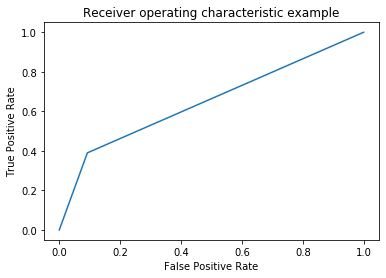

In [48]:
# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test,  Predict.round())
auc = metrics.roc_auc_score(y_test, Predict.round())
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')

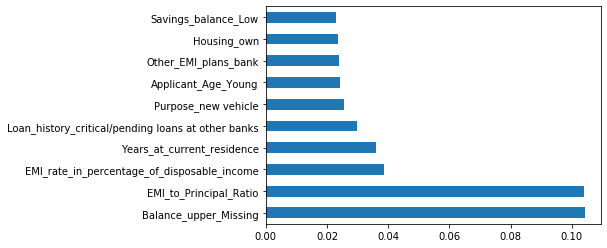

In [49]:
# Top features
feature_importances = pd.Series(RF.feature_importances_, index = X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')